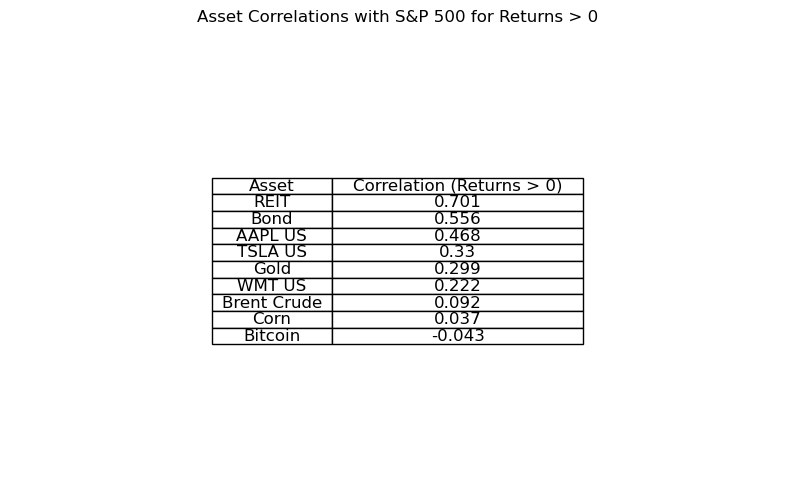

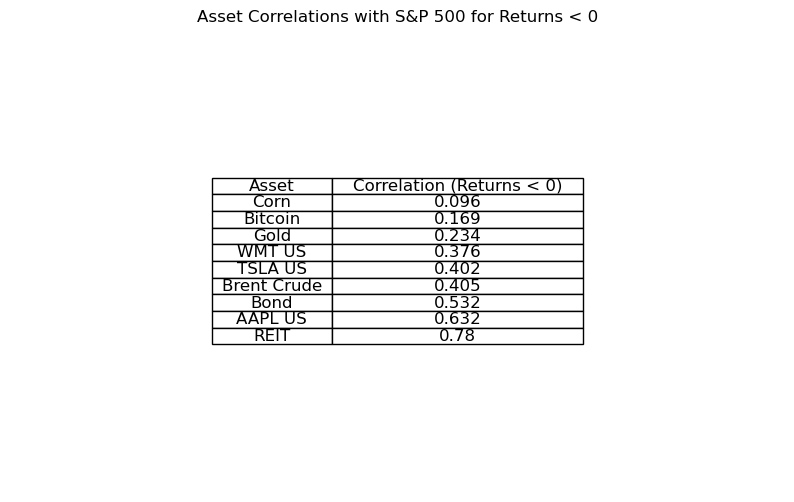

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INCREMENT = 0.002
MIN_DATA_POINTS = 5
COVID_START_DATE = '2020-03-06'

# Read data from .xlsx file
file_path = '~/diversification-project/bloomberg_data.xlsx'
original_df = pd.read_excel(file_path, index_col=0)
original_df = original_df.apply(pd.to_numeric, errors='coerce')

# Calculate returns
returns_df = original_df.pct_change().dropna()

# Split returns (pre and post COVID)
pre_covid_df = returns_df[returns_df.index < COVID_START_DATE]
post_covid_df = returns_df[returns_df.index >= COVID_START_DATE]

# Separate elements for respective periods
datasets = {
    'Pre-COVID': pre_covid_df,
    'Post-COVID': post_covid_df,
    'Whole Period': returns_df
}

all_results_dict = {}
assets = [asset for asset in original_df.columns if asset != 'S&P 500']


# Calculate max and min values to set the thresholds
max_val = returns_df['S&P 500'].max()
min_val = returns_df['S&P 500'].min()

# Create thresholds for cumulative analysis
positive_thresholds = list(np.arange(0, max_val, INCREMENT))
negative_thresholds = list(np.arange(0, min_val, -INCREMENT))

for period, data in datasets.items():
    results_dict = {}
    
    for asset in data.columns:
        if asset == 'S&P 500':  # Skip S&P 500 since it's the index
            continue

        mid_points = []
        correlations = []

        for threshold in negative_thresholds:
            subset = data[data['S&P 500'] < threshold]
    
            # Check for minimum data points
            if len(subset) < MIN_DATA_POINTS:
                continue
            
            corr = subset[asset].corr(subset['S&P 500'])
            if abs(corr) != 1:
                mid_points.append(threshold)
                correlations.append(corr)

        for threshold in positive_thresholds[1:]:
            subset = data[data['S&P 500'] > threshold]
            
            # Check for minimum data points
            if len(subset) < MIN_DATA_POINTS:
                continue
            
            corr = subset[asset].corr(subset['S&P 500'])
            if abs(corr) != 1:
                mid_points.append(threshold)
                correlations.append(corr)

        # Create dataframe for results
        df_asset = pd.DataFrame({
            'Mid-point': mid_points,
            'Correlation with S&P 500': correlations
        })

        results_dict[asset] = df_asset
    all_results_dict[period] = results_dict

assets = [asset for asset in original_df.columns if asset != 'S&P 500']


# Plotting line graphs
for asset_name in original_df.columns:
    if asset_name == 'S&P 500':
        continue

    plt.figure(figsize=(10, 6))

    for period, color in zip(['Pre-COVID', 'Post-COVID'], ['green', 'red']):
        test_asset = all_results_dict[period][asset_name]
        
        # Sort the test_asset DataFrame by 'Mid-point' column before plotting
        test_asset = test_asset.sort_values(by='Mid-point')

        if 'Mid-point' in test_asset.columns and 'Correlation with S&P 500' in test_asset.columns:
            plt.plot(test_asset['Mid-point'], test_asset['Correlation with S&P 500'], marker='o', linestyle='-', color=color, label=period)

    plt.title(f"Conditional Correlation vs Mid-point for {asset_name}")
    plt.xlabel("Mid-point")
    plt.ylabel("Conditional Correlation with S&P 500")
    plt.legend()
    plt.grid(True)

    formatted_asset_name = ''.join(e for e in asset_name if e.isalnum())
    filename = f"{formatted_asset_name}_corr.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Plotting separate bar graphs for Pre-COVID and Post-COVID
for period in ['Pre-COVID', 'Post-COVID']:
    avg_upside_corrs = []
    avg_downside_corrs = []

    for asset in original_df.columns:
        if asset == 'S&P 500':
            continue
        
        data = datasets[period]
        
        upside_corrs = data[data['S&P 500'] > 0][asset].corr(data[data['S&P 500'] > 0]['S&P 500'])
        downside_corrs = data[data['S&P 500'] < 0][asset].corr(data[data['S&P 500'] < 0]['S&P 500'])
        
        avg_upside_corrs.append(upside_corrs)
        avg_downside_corrs.append(downside_corrs)

    r = np.arange(len(assets))
    width = 0.35

    plt.figure(figsize=(12, 7))
    plt.bar(r, avg_upside_corrs, color='g', width=width, label='Avg Upside Correlation')
    plt.bar(r + width, avg_downside_corrs, color='r', width=width, label='Avg Downside Correlation')
    plt.xlabel('Assets')
    plt.ylabel('Average Correlation')
    plt.title(f'{period} - Average Upside and Downside Correlations by Asset')
    plt.xticks(r + width / 2, assets, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{period}_correlation_bar_graph.png', dpi=300)
    plt.close()

# Calculate correlations with S&P 500 for returns > 0 and returns < 0
correlations_positive = {}
correlations_negative = {}
for asset in assets:
    pos_corr = round(returns_df[returns_df['S&P 500'] > 0][asset].corr(returns_df[returns_df['S&P 500'] > 0]['S&P 500']), 3)
    neg_corr = round(returns_df[returns_df['S&P 500'] < 0][asset].corr(returns_df[returns_df['S&P 500'] < 0]['S&P 500']), 3)
    correlations_positive[asset] = pos_corr
    correlations_negative[asset] = neg_corr

# Create dataframes for the correlations
df_positive = pd.DataFrame(list(correlations_positive.items()), columns=["Asset", "Correlation (Returns > 0)"]).sort_values(by="Correlation (Returns > 0)", ascending=False)
df_negative = pd.DataFrame(list(correlations_negative.items()), columns=["Asset", "Correlation (Returns < 0)"]).sort_values(by="Correlation (Returns < 0)")

# Display tables using matplotlib and save as images
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axis('off')
tbl = ax.table(cellText=df_positive.values, colLabels=df_positive.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(df_positive.columns))))
plt.title("Asset Correlations with S&P 500 for Returns > 0")
plt.savefig("PositiveReturnsCorrelation.png", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axis('off')
tbl = ax.table(cellText=df_negative.values, colLabels=df_negative.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(df_negative.columns))))
plt.title("Asset Correlations with S&P 500 for Returns < 0")
plt.savefig("NegativeReturnsCorrelation.png", dpi=300, bbox_inches='tight')
